# **Initialization of multiagent system simulation**

Before signal acquisition by a remote sensor, the dynamic portrait of the Kuramoto multiagent system is obtained via recording of change in states of its agents.
In real life, a sensing data-center would record state dynamics on the fly.
However, for the sake of prototyping and visualization simplicity, we process and record oscillator dynamics in advance.

## Import the required libraries

*   NumPy
*   matplotlib

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
np.random.seed(1) # Set random seed for ease of monitoring
figure_figsize = (8, 3) # Figsize for all figures 
figure_dpi = 200 # DPI for all figures

## Initialize model parameters

Kuramoto model with cluster control (the modified Kuramoto model):

$$\dot{\theta}_i(t) = w_i + \rho \sum_{j=1}^{N} \Upsilon_{ij} \sin \left( \theta_j(t) - \theta_i(t) \right) + \mu_i \sin (2 \pi f_\alpha (t-t_0))$$

for $M$ clusters.
The corresponding parameters are included in the simulation environment.

*   number of agents $N$:
```
n_agents
```
*   number of clusters $M$:
```
n_clusters
```
*   coupling gain $\rho$:
```
rho
```
*   natural frequencies of oscillators $w_i$:
```
w_nat
```
*   initial oscillator phase values $\theta_i$:
```
theta_0
```
*   agent sensitivities $\mu_i$:
```
mu
```
*   cluster control frequencies $f_\alpha$:
```
f0
```
*   time shift $t_0$ (at which cluster control turns on, in seconds):
```
t_0
```
*   adjacency matrix $\Upsilon_{ij}$:
```
adj_mat
```

In [3]:
n_agents = 16
n_clusters = 4
rho = 0.5

w_disp = 4.
w_per_cluster = np.arange(1, 5) * 0.1
w_nat_matrix = np.array([(i+1) * w_disp + w_per_cluster for i in range(n_clusters)])
w_nat = w_nat_matrix.flatten()

theta_0 = 2 * np.pi * np.random.rand(n_agents)

mu = np.tile(np.arange(1, n_clusters+1) / n_clusters, n_clusters) * 1.5

f0_clust = np.random.rand(n_clusters)
f0 = np.zeros((n_agents)) + 0.5
f0[0:4] = f0[0:4] * f0_clust[0]
f0[4:8] = f0[4:8] * f0_clust[1]
f0[8:12] = f0[8:12] * f0_clust[2]
f0[12:16] = f0[12:16] * f0_clust[3]

t0 = 20.

adj_mat = np.zeros((n_agents, n_agents), dtype=np.float32)

Adjacency matrix is filled according to the graph topology, which depends on the number of agents and clusters.
As an example, further simulation is performed for the following topology:

![](https://drive.google.com/uc?export=view&id=1enKkP8P165P5SUlBDS_ujD-tZnfIg2O8)


In [4]:
def example_squares(adj_mat_empty):
    """
    Example adjacency matrix corresponding to a graph with 16 nodes connected into 4 cyclic squares, 
    which are themselves inter-connected in a larger suqare with its corners being the four mentioned cyclic agent clusters.

    Args:
        adj_mat_empty: Empty adjacency matrix

    Returns:
        adj_mat: Ready adjacency matrix
    """
    adj_mat = np.zeros_like(adj_mat_empty)

    # 1st cluster
    adj_mat[0, 3] = 1.
    adj_mat[1, 0] = 1.
    adj_mat[2, 1] = 1.
    adj_mat[3, 2] = 1.
    adj_mat[3, 4] = 1.

    # 2nd cluster
    adj_mat[0+4, 3+4] = 1.
    adj_mat[1+4, 0+4] = 1.
    adj_mat[2+4, 1+4] = 1.
    adj_mat[3+4, 2+4] = 1.
    adj_mat[6, 11] = 1.

    # 3rd cluster
    adj_mat[0+8, 3+8] = 1.
    adj_mat[1+8, 0+8] = 1.
    adj_mat[2+8, 1+8] = 1.
    adj_mat[3+8, 2+8] = 1.
    adj_mat[9, 14] = 1.

    # 4th cluster
    adj_mat[0+12, 3+12] = 1.
    adj_mat[1+12, 0+12] = 1.
    adj_mat[2+12, 1+12] = 1.
    adj_mat[3+12, 2+12] = 1.
    adj_mat[12, 1] = 1.

    return adj_mat

In [5]:
adj_mat = example_squares(adj_mat)

## Simulation parameters

Main parameters:
*   time step (in seconds):
```
dt
```
*   total simulation time (in seconds):
```
sim_time
```
*   total number of iterations:
```
n_iterationserations
```
*   iteration shift according to the time shift:
```
iteration_shift
```

Simulation recording arrays:
*   $\theta$ recording:
```
thetas
```
*   $\dot{\theta}$ recording:
```
thetas_dot
```


In [6]:
dt = 0.01
sim_time = 60.
n_iterations = int(sim_time / dt)
iteration_shift = int(t0 / dt)
time_vals = np.linspace(0., sim_time, n_iterations)

# Progress recording
thetas = np.zeros((n_agents, n_iterations))
thetas_dot = np.zeros_like(thetas)

## Simulation run
The states of oscillator agents iteratively update according to the local and cluster control inputs in the midified Kuramoto model.
The cluster control input turns on at $t_0$, i.e. when the iteration number surpasses the iteration shift.

In [7]:
def update_states(theta, iteration):
    """
    Update states of the agents.

    Args:
        theta: Current states
        iteration: Simulation iteration

    Returns:
        theta_new: New states
    """
    theta_mat = np.repeat(theta.reshape(n_agents, 1), n_agents, axis=1)
    diffs = theta_mat.T - theta_mat
    sins = np.sin(diffs)
    sins = adj_mat * sins
    sums_sins = np.sum(sins, axis=1)
    sums_diffs = np.sum(diffs, axis=1)
    
    if iteration >= iteration_shift:
        theta_new = theta + dt * (w_nat + 1 * rho * sums_sins + 
                                  1 * np.multiply(mu, np.sin(2 * f0 * np.pi * (iteration-iteration_shift) * dt)))
    else:
        theta_new = theta + dt * (w_nat + 1 * rho * sums_sins)
    
    return theta_new

In [8]:
theta = theta_0
for iteration in range(n_iterations):
    theta_new = update_states(theta, iteration)
    thetas[:, iteration] = theta 
    thetas_dot[:, iteration] = np.divide(theta_new - theta, dt)
    theta = theta_new

Visualize agent dynamic trajectories.

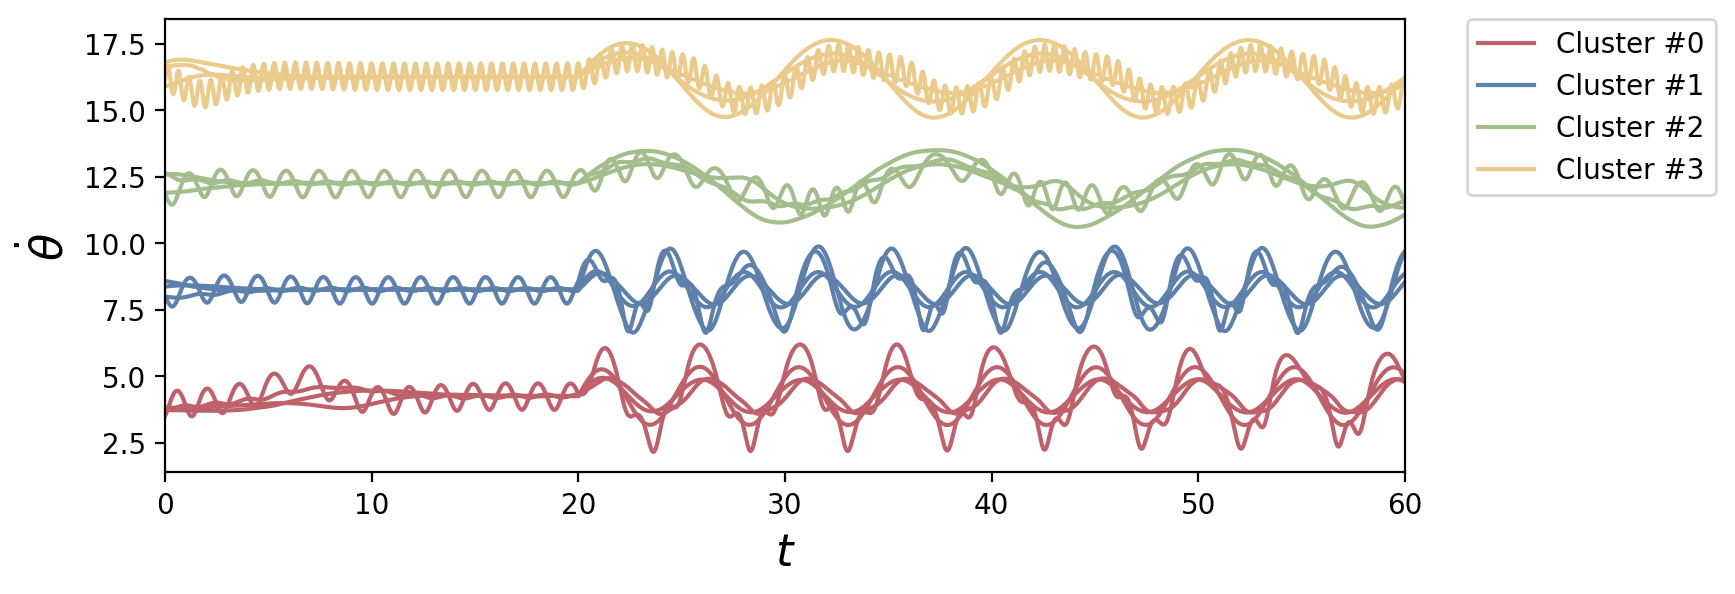

In [9]:
plt.figure(figsize=figure_figsize, dpi=figure_dpi)
colors = ['#BF616A', '#5E81AC' , '#A3BE8C', '#EBCB8B']
for i in range(n_agents):
    color = colors[int(i/n_clusters)]
    label = f"Cluster #{int(i/n_clusters)}" if i % n_clusters == 0 else ""
    plt.plot(time_vals, thetas_dot[i], '-', color=color, label=label)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\dot{\theta}$', fontsize=16)
plt.xlim(0, n_iterations * dt)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# **Data asquisition by a remote sensor**
After all the state transitions were recorded, they are ready to be processed by a remote sensing data-center.


## Import the required libraries

*   SciPy

In [10]:
import scipy.optimize as so

import warnings
warnings.filterwarnings('ignore') # Disable warnings, which appear during L1 reconstruction

## State space measurements

Sensor parameters:
*   minimum distance between trajectories, at which sensor can resolve them
```
sensor_resolution
```
*   amount of time at which sensor measures trajectories
```
sensor_exposure
```
*   upper and lower limits of sensor's field of view
```
fov_top
for_bot
```


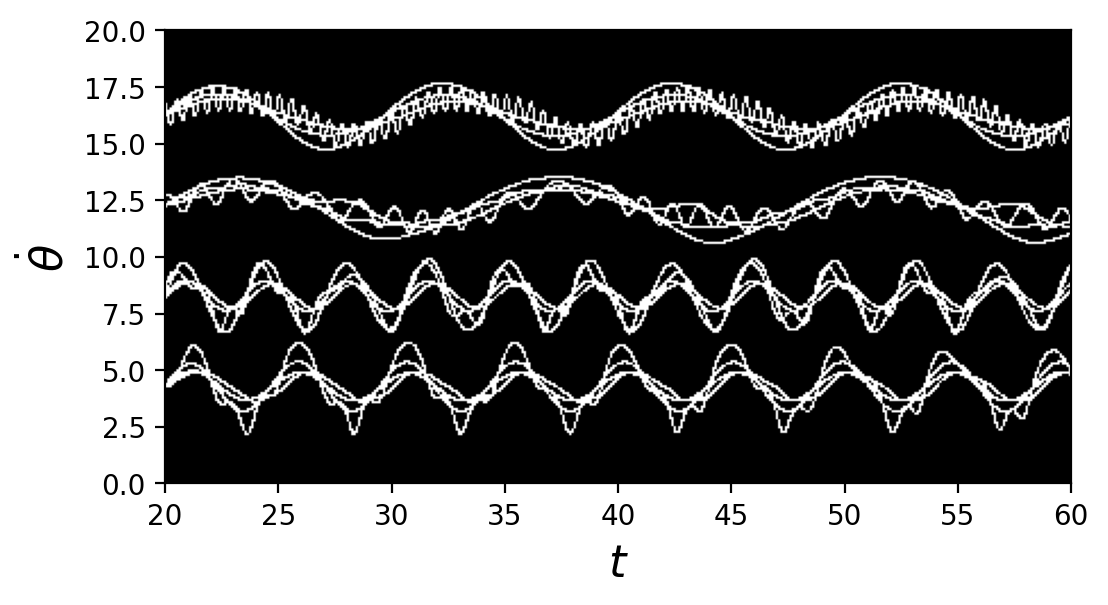

In [11]:
sensor_resolution = .1
sensor_exposure = .1
fov_top = 20.
fov_bot = 0.
n_pixels = int(fov_top // sensor_resolution)
n_frames = int((sim_time - t0) // sensor_exposure)
pixel_ticks = np.linspace(fov_bot, fov_top, n_pixels+1)
frame_ticks = np.arange(t0, sim_time, sensor_exposure)
time_tiles = np.tile(np.linspace(t0, sim_time, n_iterations-iteration_shift), n_agents)
thetas_dot_tiles = thetas_dot[:, iteration_shift:].flatten()

thd_hist, _, _ = np.histogram2d(time_tiles, thetas_dot_tiles, density=True, bins=[frame_ticks, pixel_ticks])

thd_b = np.array(thd_hist.T)
thd_b[thd_b > 0.] = 1. # Frames, which emulate 1 bit response to agents

plt.figure(figsize=figure_figsize, dpi=figure_dpi)
plt.imshow(thd_b, origin='lower', cmap='gray', extent=[t0, sim_time, fov_bot, fov_top])
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\dot{\theta}$', fontsize=16)
plt.show()


## Compression of the frames

According to the compressive sensing methodology (see [the intro article](https://en.wikipedia.org/wiki/Compressed_sensing)), the sparse columns-frames of the above image may be effectively represented in a lower-dimensional space.
With that being said, each of the columns is compressed.

In [12]:
cs_s = np.zeros((n_frames))
for t in range(n_frames):
    cs_s[t] = n_pixels - np.sum(thd_b[:, t] == 0.)
    
cs_max_s = cs_s.max()
cs_avg_s = cs_s.mean()
print("Frame length:", n_pixels)
print("Average number of non-zero elements:", cs_avg_s)
print("Maximum number of non-zero elements: ", cs_max_s)

Frame length: 199
Average number of non-zero elements: 24.784461152882205
Maximum number of non-zero elements:  32.0


The signal $x$ is compressed as follows:

$$y = Ax,$$

where $A$ is the measurement matrix. 
Before compression, we should choose the dimensionality $m$ of $y$.
A fine heuristic is $m = c \cdot s$, where $s$ is signal sparsity and $c$ is a constant between $2$ and $4$.

In [13]:
c = 3
cs_m = int(c * cs_avg_s)
print("average sparsity: ", cs_avg_s)
print("m: ", cs_m)

a_mat = np.random.randn(cs_m, n_pixels) * 1/cs_m
compressed_data = np.dot(a_mat, thd_b)

average sparsity:  24.784461152882205
m:  74


## Frame reconstruction

The reconstruction is performed with the help of linear programming.

In [14]:
thd_b_decomp = np.zeros_like(thd_b) # Estimated frames after reconstruction
for t in range(n_frames):
    x_hat = so.linprog(c=np.ones(n_pixels), A_eq=a_mat, b_eq=compressed_data[:, t])['x']
    thd_b_decomp[:, t] = x_hat

Since the reconstructed frames consist of float values, a thresholding is applied. 
The threshold value for each frame is calculated as a multiple of its average.
The multiplier $2$ is chosen as a fine heuristic value. 

(199, 399)


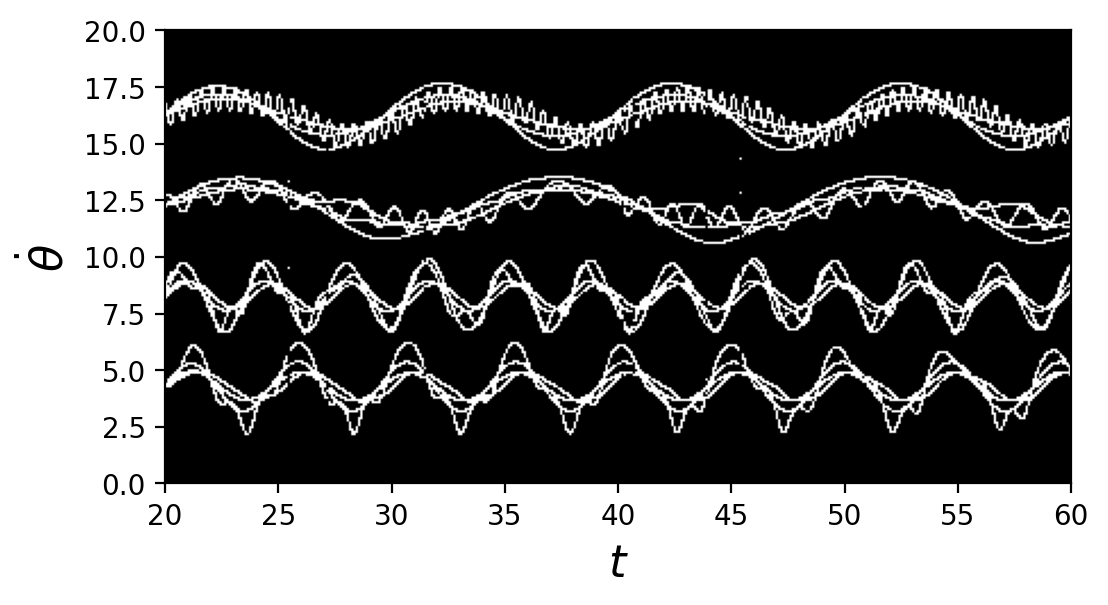

In [15]:
thd_b_decomp_thresh = np.array(thd_b_decomp)
thresh_means = 5 * np.mean(thd_b_decomp_thresh, axis=0)
thd_b_decomp_thresh[thd_b_decomp_thresh < thresh_means] = 0
thd_b_decomp_thresh[thd_b_decomp_thresh > 0] = 1
print(thd_b_decomp_thresh.shape)
plt.figure(figsize=figure_figsize, dpi=figure_dpi)
plt.imshow(thd_b_decomp_thresh, origin='lower', cmap='gray', extent=[t0, sim_time, fov_bot, fov_top])
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\dot{\theta}$', fontsize=16)
plt.show()

## Cluster identification

In order to find clusters, agglomerative hierarchical clustering iterative algorithm is exploited.
At the first iteration, the algorithm treats each data point as separate clusters.
At each next iteration two closest clusters (where closeness is measured according to a defined metric function) connect into one whole.
At the last iteration, the most distant clusters are connected into one.

In the example with four clusters it is particularly interesting to identify exactly those four clusters. 
By guessing possible distance between clusters, a corresponding threshold can be set for it to separate clusters.
This process is illustrated on a so-called dendogram below:

![](https://www.researchgate.net/profile/Yuen-Hsien-Tseng/publication/236586443/figure/fig1/AS:614328034152479@1523478625769/A-dendrogram-showing-the-result-of-the-hierarchical-clustering-When-a-threshold-say.png)

The clusters are denoted by red lines.

In [16]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

def get_cluster_data(x, delta, min_clust):
    """
    Get cluster data given a sparse vector consisting of either 0 or 1.
    The function identifies clusters according to euclidean distances between 1's.

    Args:
        x: Sparse data vector
        delta: Threshold
        min_clust: Min size of a cluster, anything below would be considered as an outlier

    Returns:
        l: Linkage data for a dendogram
        centroids: Positions of cluster centroids 
    """
    # Get positions (indices) of 1's 
    x_pos = np.nonzero(x) 
    l = linkage(np.transpose(x_pos), "single")
    x_pos = x_pos[0]
    clusters = fcluster(l, delta, criterion='distance')-1
    n_clust = clusters.max()+1
    cluster_idx = []

    # Remove small outlier clusters
    for i in range(n_clust): 
        cluster_size = np.count_nonzero(clusters == i)
        if cluster_size < min_cluster:
            x_pos = np.delete(x_pos, np.where(clusters == i))
            clusters = np.delete(clusters, np.where(clusters == i))
        else:
            cluster_idx.append(i)

    # Get centroids as means of index values
    if len(clusters) == 0:
        centroids = []
    else:
        n_clust = clusters.max()
        centroids = np.zeros((len(cluster_idx)))
        for idx, i in enumerate(cluster_idx): 
            centroids[idx] = np.mean(x_pos[clusters == i])
    
    return centroids, l

In order to calculate accuracy of cluster identification, the number of clusters found in a frame is compared with the true number of clusters (which is $4$).
Total proportion of matches over all frames indicates clusterization accuracy.

In [17]:
def clusterization_accuracy(pred_n_clusters, true_n_clusters):
    """
    Get clusterization accuracy.

    Args:
        pred_n_clusters: Number of clusters identified by an algorithm
        true_n_clusters: True number of clusters

    Returns:
        accuracy: Calculated accuracy
    """
    total = len(pred_n_clusters)
    positive = np.sum(np.array(pred_n_clusters) == true_n_clusters)
    accuracy = positive / total

    return accuracy

Cluster centroids can be visualized.

In [18]:
def clusterize_frames(thd, delta, min_cluster):
    """
    Visualize cluster centroids and get metrics.

    Args:
        thd: Array of frames
        delta: Clusterization threshold
        min_clust: Min size of a cluster, anything below would be considered as an outlier

    Returns:
        accuracy: Calculated accuracy
    """
    plt.figure(figsize=figure_figsize, dpi=figure_dpi)
    plt.imshow(thd, origin='lower', cmap='gray', extent=[t0, sim_time, fov_bot, fov_top])

    cmax = []
    for i in range(frame_ticks.size-1):
        x = thd[:, i]
        c, l = get_cluster_data(x, delta, min_cluster) 
        if len(c) > 0:
            c = c * sensor_resolution
            cmax.append(c.size)
            t_val = np.full(c.shape, frame_ticks[i]) + sensor_exposure * 0.5
            plt.scatter(t_val, c, color='r', s=0.3)

    accuracy = clusterization_accuracy(cmax, n_clusters)

    plt.xlabel(r'$t$', fontsize=16)
    plt.ylabel(r'$\dot{\theta}$', fontsize=16)
    plt.xlim(t0, sim_time)
    plt.ylim(fov_bot, fov_top)
    plt.show()

    return accuracy

In [19]:
delta = 8
min_cluster = 2

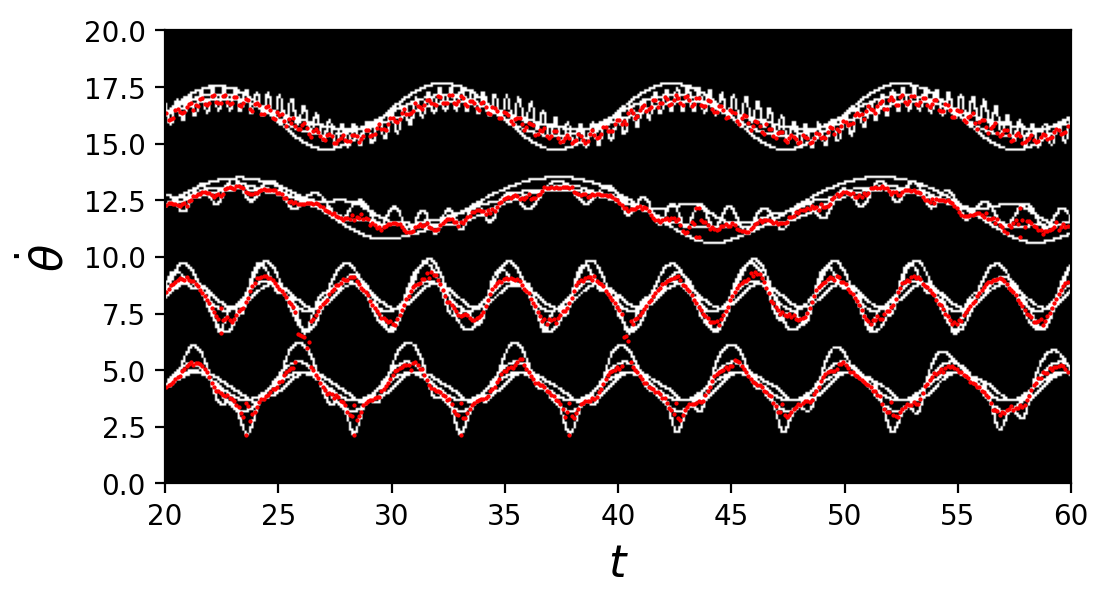

Original frames clusterization accuracy: 0.9573934837092731


In [20]:
original_accuracy = clusterize_frames(thd_b, delta, min_cluster)
print("Original frames clusterization accuracy:", original_accuracy)

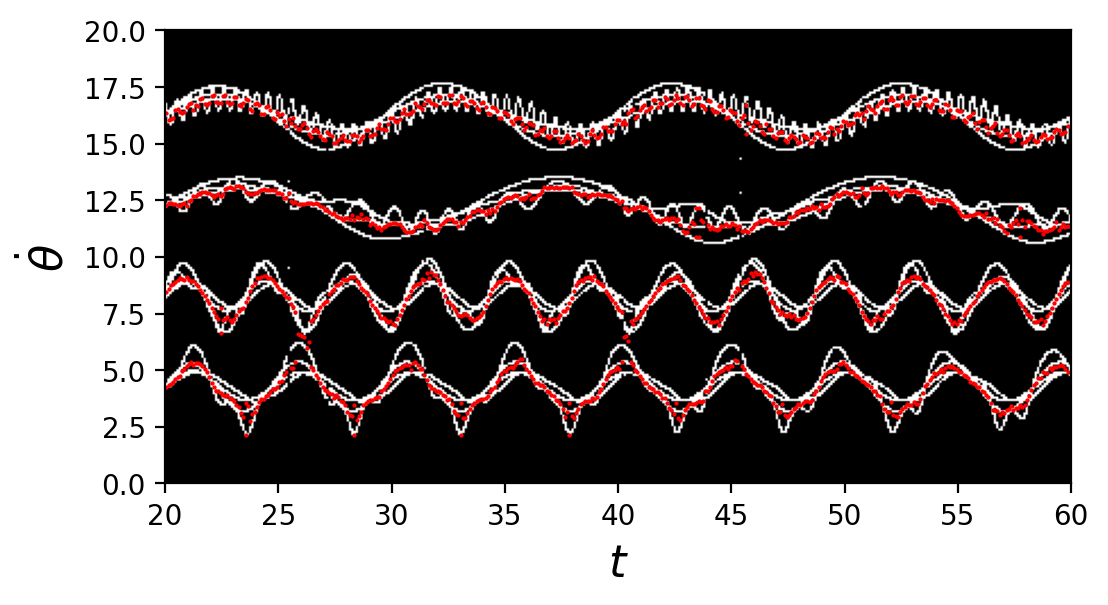

Reconstructed frames clusterization accuracy: 0.9473684210526315


In [21]:
reconst_accuracy = clusterize_frames(thd_b_decomp_thresh, delta, min_cluster)
print("Reconstructed frames clusterization accuracy:", reconst_accuracy)